## Use models to make cell population-specific predictions

Here, we use the the three different types of models (tissue-specific bulk, tissue-specific pseudobulk, and cell population-specific pseudobulk) to make cell population-specific predictions (Figure 2, S7). 

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns


In [2]:
def predict_sc(filename, fn_bulk, tissue, bulk = True):
    
    fn_cp_pb = filename + tissue + '/cp_specific/logmean_zscore_multitask_'
    fn_t_pb = filename + tissue + '/tissue_specific/logmean_zscore_All_'
        
    # Find celltypes in the data
    filename2 = filename + tissue + '/pseudobulk.csv'
    celltypes = np.array(pd.read_csv(filename2, index_col=0).columns, dtype='str')[1:]
    
    if not bulk:
        corr_all = pd.DataFrame(np.zeros((len(celltypes)*2, 3)), columns=['tissue','model','med_corr'])
        corr_all = corr_all.astype({"tissue": str, "model": str})
        corr_all['model'].values[0:len(celltypes)] = "scEP_{cp,pb}"
        corr_all['model'].values[len(celltypes):len(celltypes)*2] = "scEP_{t,pb}"
                
    else:
        corr_all = pd.DataFrame(np.zeros((len(celltypes)*3, 3)), columns=['tissue','model','med_corr'])
        corr_all = corr_all.astype({"tissue": str, "model": str})
        corr_all['model'].values[0:len(celltypes)] = "scEP_{cp,pb}"
        corr_all['model'].values[len(celltypes):len(celltypes)*2] = "scEP_{t,pb}"
        corr_all['model'].values[len(celltypes)*2:len(celltypes)*3] = "scEP_{t,b}"
            
    inc_perf = pd.DataFrame(np.zeros((len(celltypes),5)), columns=['celltype','gain', 'corr', 'tissue', 'perc'])
    inc_perf = inc_perf.astype({"celltype": str, "tissue": str})

    c = 0 #counter
    
    for idx, ct in enumerate(celltypes):

        corr_folds = pd.DataFrame(np.zeros((20,3)), columns=['sc','pseudo','bulk'])
        corr_true = np.zeros((20,))
        
        for i in range(0,20):
            
            # Read true labels
            pred_file = fn_cp_pb + str(i) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
            y = pd.read_pickle(pred_file)
            y_true = np.asarray(y['y_true'])[:,idx]
            
            y_pred_sc = 0
            y_pred_pseudo = 0
            y_pred_bulk = 0
            
            # Cell population-specific model
            for j in range(5):
                pred_file = fn_cp_pb + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
                y = pd.read_pickle(pred_file)
                y_pred = np.asarray(y['y_pred'])[:,idx]
                y_pred_sc += y_pred/5
                
            # Tissue-specific model (pseudobulk)
            for j in range(5):
                pred_file = fn_t_pb + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
                y = pd.read_pickle(pred_file)
                y_pred = np.asarray(y['y_pred'])
                y_pred_pseudo += y_pred/5
                y_true_pseudo = np.asarray(y['y_true'])
            
            # Tissue-specific model (bulk)
            if bulk:
                for j in range(5):
                    pred_file = fn_bulk + '_' + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
                    y = pd.read_pickle(pred_file)
                    y_pred = np.asarray(y['y_pred'])
                    y_pred_bulk += y_pred/5
            
            # Performance cp-specific model
            corr,_ = pearsonr(y_true, y_pred_sc)
            corr_folds['sc'].values[i] = corr
            c += 1
            
            # Performance tissue-specific model (pseudobulk)
            corr2,_ = pearsonr(y_true, y_pred_pseudo)            
            corr_folds['pseudo'].values[i] = corr2
            c += 1
            
            # Similarity between cp and tissue (for Figure 2C, S7B)
            corrtrue, _ = pearsonr(y_true, y_true_pseudo)
            corr_true[i] = corrtrue
            
            # Performance of tissue-specific model (bulk)
            if bulk:
                corr,_ = pearsonr(y_true, y_pred_bulk)
                corr_folds['bulk'].values[i] = corr


        med_corr = np.median(corr_folds, axis=0)
        corr_all['med_corr'].values[idx] = med_corr[0]
        corr_all['med_corr'].values[idx+len(celltypes)] = med_corr[1]
        inc_perf['gain'].values[idx] = med_corr[0] - med_corr[1]
        inc_perf['celltype'].values[idx] = ct
        inc_perf['corr'].values[idx] = np.median(corr_true)

        if bulk:
            corr_all['med_corr'].values[idx+len(celltypes)*2] = med_corr[2]

    return corr_all, inc_perf


#### FACS-sorted Smart-seq2

In [3]:
tissues_Bulk = ['Spleen', 'Lung', 'Marrow','Limb_Muscle']
tissues = ['spleen', 'lung', 'marrow','muscle', 'gland']

corr_all = pd.DataFrame(np.zeros((0,3)), columns=['tissue','model','med_corr'])
corr_all = corr_all.astype({"tissue": str, "model": str})

inc_perf = pd.DataFrame(np.zeros((0,5)), columns=['celltype','gain', 'corr', 'tissue', 'perc'])
inc_perf = inc_perf.astype({"celltype": str, "tissue": str})

fn = '../../Zenodo/mouse/TM_FACS_SM2/'

for i,t in enumerate(tissues):

    if t != 'gland':
        fn_bulk = '../../Zenodo/mouse/TM_bulk/logmean_zscore_' + tissues_Bulk[i]
        corr_tp, inc_tp = predict_sc(fn, fn_bulk, t)
    else:
        corr_tp, inc_tp = predict_sc(fn, fn_bulk, t, bulk = False)
    
    corr_tp['tissue'].values[:] = t
    inc_tp['tissue'].values[:] = t

    corr_all = pd.concat([corr_all, corr_tp])
    inc_perf = pd.concat([inc_perf, inc_tp])
       


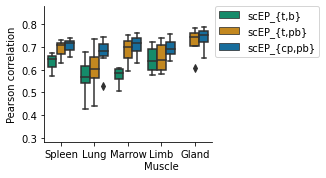

In [4]:
# Figure 2B
c = sns.color_palette('colorblind', n_colors=3)
c_new = []
c_new.append(matplotlib.colors.to_rgba(c[2], 1))
c_new.append(matplotlib.colors.to_rgba(c[1], 1))
c_new.append(matplotlib.colors.to_rgba(c[0], 1))

fig, ax = plt.subplots(figsize=[3,2.5])
g = sns.boxplot(data = corr_all, x='tissue', y='med_corr', hue='model', palette=c_new, 
                hue_order=['scEP_{t,b}', 'scEP_{t,pb}', 'scEP_{cp,pb}']
           )
sns.despine()
g.set_xticklabels(['Spleen', 'Lung', 'Marrow', 'Limb\nMuscle', 'Gland'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim([0.28,0.88])
plt.xlabel('')
plt.ylabel('Pearson correlation')
plt.show()


In [5]:
inc_perf = inc_perf.sort_values(['tissue', 'celltype'])

prop = pd.read_csv('../../Zenodo/mouse/prop_celltypes.csv', index_col=0)
prop = prop.sort_values(['tissue', 'celltype'])

prop_FACS = prop.iloc[np.isin(prop.tissue, np.unique(prop.tissue)[[1,3,5,7,9]])]

inc_perf['perc'].values[:] = prop_FACS['proportion'].values


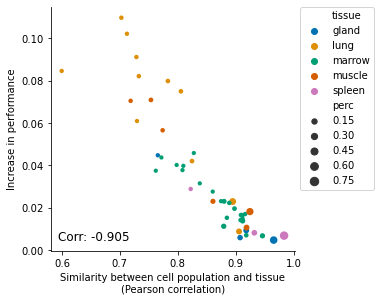

In [6]:
# Figure 2C
c, _ = pearsonr(inc_perf['corr'], inc_perf['gain'])

fig, ax = plt.subplots(figsize=(4.5,4.5))

sns.scatterplot(data = inc_perf, x='corr', y='gain', hue='tissue', palette='colorblind', size='perc', linewidth=0)
sns.despine()
plt.xlabel('Similarity between cell population and tissue\n(Pearson correlation)')
plt.ylabel('Increase in performance')
ax.set_box_aspect(1)
ax.text(0.03, 0.03, 'Corr: ' + str(np.round(c,3)),
    verticalalignment='bottom', horizontalalignment='left',
    transform=ax.transAxes, fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


#### 10X

In [7]:
tissues_Bulk = ['Spleen', 'Lung', 'Marrow','Limb_Muscle']
tissues = ['spleen', 'lung', 'marrow','muscle', 'gland']

corr_all_10X = pd.DataFrame(np.zeros((0,3)), columns=['tissue','model','med_corr'])
corr_all_10X = corr_all_10X.astype({"tissue": str, "model": str})

inc_perf_10X = pd.DataFrame(np.zeros((0,5)), columns=['celltype','gain', 'corr', 'tissue', 'perc'])
inc_perf_10X = inc_perf_10X.astype({"celltype": str, "tissue": str})

fn = '../../Zenodo/mouse/TM_10X/'

for i,t in enumerate(tissues):

    if t != 'gland':
        fn_bulk = '../../Zenodo/mouse/TM_bulk/logmean_zscore_' + tissues_Bulk[i]
        corr_tp, inc_tp = predict_sc(fn, fn_bulk, t)
    else:
        corr_tp, inc_tp = predict_sc(fn, fn_bulk, t, bulk = False)
    
    corr_tp['tissue'].values[:] = t
    inc_tp['tissue'].values[:] = t

    corr_all_10X = pd.concat([corr_all_10X, corr_tp])
    inc_perf_10X = pd.concat([inc_perf_10X, inc_tp])
       


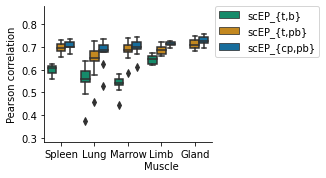

In [8]:
# Figure S7A
c = sns.color_palette('colorblind', n_colors=3)
c_new = []
c_new.append(matplotlib.colors.to_rgba(c[2], 1))
c_new.append(matplotlib.colors.to_rgba(c[1], 1))
c_new.append(matplotlib.colors.to_rgba(c[0], 1))

fig, ax = plt.subplots(figsize=[3,2.5])
g = sns.boxplot(data = corr_all_10X, x='tissue', y='med_corr', hue='model', palette=c_new, 
                hue_order=['scEP_{t,b}', 'scEP_{t,pb}', 'scEP_{cp,pb}']
           )
sns.despine()
g.set_xticklabels(['Spleen', 'Lung', 'Marrow', 'Limb\nMuscle', 'Gland'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim([0.28,0.88])
plt.xlabel('')
plt.ylabel('Pearson correlation')
plt.show()


In [9]:
inc_perf_10X = inc_perf_10X.sort_values(['tissue', 'celltype'])

prop_10X = prop.iloc[np.isin(prop.tissue, np.unique(prop.tissue)[[0,2,4,6,8]])]

inc_perf_10X['perc'].values[:] = prop_10X['proportion'].values


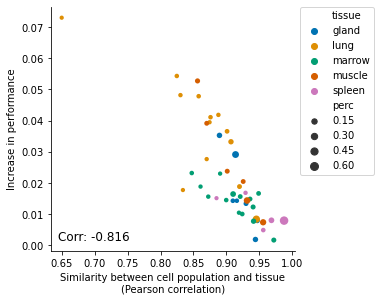

In [10]:
# Figure S7B
c, _ = pearsonr(inc_perf_10X['corr'], inc_perf_10X['gain'])

fig, ax = plt.subplots(figsize=(4.5,4.5))

sns.scatterplot(data = inc_perf_10X, x='corr', y='gain', hue='tissue', palette='colorblind', size='perc', linewidth=0)
sns.despine()
plt.xlabel('Similarity between cell population and tissue\n(Pearson correlation)')
plt.ylabel('Increase in performance')
ax.set_box_aspect(1)
ax.text(0.03, 0.03, 'Corr: ' + str(np.round(c,3)),
    verticalalignment='bottom', horizontalalignment='left',
    transform=ax.transAxes, fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


### Example B cells - Lung-FACS

For B cells in the Lung-FACS dataset, we see the biggest increase in performance. Can we explain why? (Figure 2D-F)


In [11]:
def get_pred(filename, ct):
    # Function that returns the true values for a cell populations and the predictions by the 
    # tissue-specific and cell population-specific models.
    
    predval_tissue=[]
    predval_cp=[]
    trueval=[]
    
    filename2 = filename + 'pseudobulk.csv'
    celltypes = np.array(pd.read_csv(filename2, index_col=0).columns, 
                         dtype='str')
    ct_yes = np.where(celltypes == ct)[0]
    
    for i in range(0,20):
        
        y_pred_tissue = 0
        y_pred_cp = 0
        j = 0
        count = 0
                
        # True expression
        file = filename + 'cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(0) + '/results_testdata_best.pkl'
        y = pd.read_pickle(file)
        y_true = np.asarray(y['y_true'])
        
        for j in range(5):
            # Predicted expression cell pop-specific
            file = filename + 'cp_specific/logmean_zscore_multitask_' + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file)
            y_pred_cp = y_pred_cp + np.asarray(y['y_pred'])/5

            # Predicted expression tissue specific
            file = filename + 'tissue_specific/logmean_zscore_All_' + str(i) + '/logs_dir' + str(j) + '/results_testdata_best.pkl'
            y = pd.read_pickle(file)
            y_pred_tissue = y_pred_tissue + np.asarray(y['y_pred'])/5
        
        predval_tissue.extend(y_pred_tissue)
        predval_cp.extend(y_pred_cp[:,ct_yes-1])
        trueval.extend(y_true[:,ct_yes-1])
        
    predval_cp = np.asarray(np.squeeze(predval_cp))
    predval_tissue = np.asarray(np.squeeze(predval_tissue))
    trueval = np.asarray(np.squeeze(trueval))
            
    return predval_cp, predval_tissue, trueval

In [12]:
### B cells 

pred_B, pred_Lung, true_B = get_pred('../../Zenodo/mouse/TM_FACS_SM2/lung/', 'B cell')

print('Performance cp-specific model: ')
print(pearsonr(pred_B, true_B))
print('Performance tissue-specific model: ')
print(pearsonr(pred_Lung, true_B))

Performance cp-specific model: 
(0.6691898638210882, 0.0)
Performance tissue-specific model: 
(0.5656032745061595, 0.0)


### Undo the z-score before we can compare the predictions

And add the gene names, so we know which genes we are talking about!

In [13]:
y_true_original = pd.read_csv('../../Zenodo/mouse/TM_FACS_SM2/lung/pseudobulk.csv', index_col=0).iloc[:,:2]
y_true_original.iloc[:5]

,All,B cell
0610007C21Rik,2.256810,1.880513
0610007L01Rik,1.626533,1.560724
0610007P08Rik,0.834285,0.188608
0610007P14Rik,1.518801,1.599768
0610007P22Rik,1.253626,0.793128


In [14]:
import h5py

hf = h5py.File('../../Zenodo/mouse/mouse_seq_hl.h5', 'r', libver='latest', swmr=True)
gn = np.asarray(hf['geneName']).astype('U30')
hf.close()

In [15]:
from sklearn.model_selection import KFold

numgenes = 20467
idx_all = np.arange(0,numgenes)
kf = KFold(n_splits=20, shuffle=True, random_state=1)
counter=0
counter2=0
gn_order=np.zeros_like(gn)

## Add a list here with genenames that are in the training set
gn_train = []

## Add a list here with genenames that are in the test set
gn_test = []

## --> we can use these lists with genenames than later on to undo the normalization

for train_val_idx, idx_test in kf.split(idx_all):
    gn_order[counter:(counter+len(idx_test))] = gn[idx_test]
    counter += len(idx_test)
    np.random.seed(counter2)
    counter2 += 1
    idx_rest = np.random.permutation(numgenes-len(idx_test))
    idx_val = train_val_idx[idx_rest[:1000]]
    idx_train = train_val_idx[idx_rest[1000:]]
    
    gn_train.append(gn[idx_train])
    gn_test.append(gn[idx_test])
    

In [16]:
true_B = pd.DataFrame(true_B, index = gn_order)
pred_B = pd.DataFrame(pred_B, index = gn_order)
pred_Lung = pd.DataFrame(pred_Lung, index = gn_order)

y_true_original = y_true_original.loc[gn_order]

In [17]:
import copy as cp
from sklearn.preprocessing import StandardScaler

true_B_org = pd.DataFrame(np.zeros_like(true_B), index=true_B.index)
pred_B_org = pd.DataFrame(np.zeros_like(true_B), index=true_B.index)
pred_Lung_org = pd.DataFrame(np.zeros_like(true_B), index=true_B.index)

for i in range(20):
    
    # For the B cell predictions
    # Learn zscore from training data
    scaler = StandardScaler()
    scaler.fit(np.reshape(y_true_original.loc[gn_train[i]]['B cell'].values, (-1,1)))

    # Transforming B cells back
    true_B_org.loc[gn_test[i]] = scaler.inverse_transform(true_B.loc[gn_test[i]])
    pred_B_org.loc[gn_test[i]] = scaler.inverse_transform(pred_B.loc[gn_test[i]])
    
    # For the Lung predictions
    scaler = StandardScaler()
    scaler.fit(np.reshape(y_true_original.loc[gn_train[i]]['All'].values, (-1,1)))

    # Transforming tissue-specific back
    pred_Lung_org.loc[gn_test[i]] = scaler.inverse_transform(pred_Lung.loc[gn_test[i]])



In [18]:
true_B_org = np.squeeze(true_B_org.values)
pred_B_org = np.squeeze(pred_B_org.values)
pred_Lung_org = np.squeeze(pred_Lung_org.values)

In [19]:
high_Lung = pred_Lung_org - true_B_org
idx = np.where(high_Lung > 4)[0]

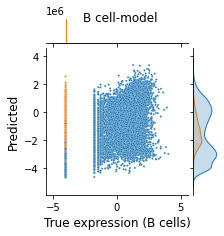

In [20]:
hue_ = np.zeros_like(true_B_org)
hue_[idx] = 1

h = sns.jointplot(x=true_B_org, y=pred_B_org, hue=hue_, s=4, legend=False, height=3, rasterized=True)
h.set_axis_labels('x', 'y', fontsize=12)
h.ax_joint.set_xlabel('True expression (B cells)')
h.ax_joint.set_ylabel('Predicted')
h.fig.suptitle('B cell-model')

plt.show()


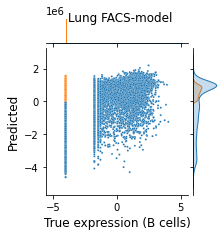

In [21]:
hue_ = np.zeros_like(true_B_org)
hue_[idx] = 1

h = sns.jointplot(x=true_B_org, y=pred_Lung_org, hue=hue_, s=4, legend=False, height=3, rasterized=True)
h.set_axis_labels('x', 'y', fontsize=12)
h.ax_joint.set_xlabel('True expression (B cells)')
h.ax_joint.set_ylabel('Predicted')
h.fig.suptitle('Lung FACS-model')

plt.show()


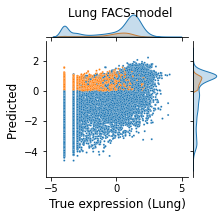

In [22]:
hue_ = np.zeros_like(true_B_org)
hue_[idx] = 1



h = sns.jointplot(x=y_true_original['All'], y=pred_Lung_org, hue=hue_, s=4, legend=False, height=3, rasterized=True)
h.set_axis_labels('x', 'y', fontsize=12)
h.ax_joint.set_xlabel('True expression (Lung)')
h.ax_joint.set_ylabel('Predicted ')
h.fig.suptitle('Lung FACS-model')
plt.show()
